In [1]:
# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from dataCleaning import DataCleaner
from ESN import EchoState
from Loss import loss

In [2]:
data_months = range(1, 13)
data_years = range(2018, 2020)
u_dim = 50

topK = 2
data = {}
cleaner = DataCleaner(columns=["OptionType", "expirydate", "date", "strike", "spotclose", "close2", "volume"],
                          date_columns=["date", "expirydate"], length_return = u_dim, verbose=False)
for year in data_years:
    for month in data_months:
        if month < 10:
            name = "SPX_{}0{}_1day".format(year, month)
        else:
            name = "SPX_{}{}_1day".format(year, month)
        if not path.exists("./SPXdata/{}.csv".format(name)):
            continue
        cleaner.insert_data(data, name, "USD3MTD156N", topK)
#         print("Added Year: {}, Month: {} data".format(year, month))

num_days = cleaner.get_num_days(data)
num_observations = cleaner.get_num_observation()
# data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 450 days of data
Attached 900 option observations


In [3]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

@jit(nopython=True)
def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [4]:
np.random.seed(1234)
gradient = grad(loss)

theta_dim = 10
connectivity = 0.4
spectral_radius = 0.98
bday_p_year = 252
alpha = 5
bias = -7

v_scale = 100.0
target_var = 4
chi_mu = math.sqrt(2)* math.gamma((theta_dim+1)/2) / math.gamma(theta_dim/2)
W_scale = target_var+chi_mu

# initialize ESN dynamics
ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
W = np.eye(theta_dim)*W_scale
v = v_scale


for em_itr in range(150):
    dt=1
    points = MerweScaledSigmaPoints(theta_dim, alpha=.001, beta=2., kappa=0)
    ukf = UnscentedKalmanFilter(dim_x=ESN.theta_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
    ukf.x = np.ones(ESN.theta_dim)* 0.002 # initial state
    ukf.P *= 0.01 # initial uncertainty
    ukf.R = np.diag([v]*topK) # 1 standard
    ukf.Q = W

    ms = [ukf.x.copy()]
    Cs = [ukf.P.copy()]
    u_quad_s = []
    ps = []
    rs = []
    ys = []
    Ks = []
    us = []
    Ts = []

    all_days = sorted(list(data.keys()))
    for day in all_days:
        # get observable data
        ## Stock Wise and market wise data
        p_t = data[day][0]["spotclose"].values[0]
        r_t = data[day][1] / bday_p_year
        u_t = data[day][2].reshape([-1])

        ## Option wise data
        y_t = data[day][0]["close2"].values
        K_t = data[day][0]["strike"].values
        today = [d.date() for d in data[day][0]["date"]]
        expireday = [d.date() for d in data[day][0]["expirydate"]]
        T_t = np.busday_count(today, expireday)


        ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
        ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
        ms.append(ukf.x_post.copy())
        Cs.append(ukf.P_post.copy())
        u_quad_s.append(np.power(u_t,2))
        us.append(u_t)
        ps.append(p_t)
        rs.append(r_t)
        ys.append(y_t)
        Ks.append(K_t)
        Ts.append(T_t)

    ms = np.array(ms)
    Cs = np.array(Cs)
    ms_s, Cs_s, _, cvs_s = ukf.rts_smoother(ms, Cs, fx=ESNf, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_s=us)


    params = [ESN.G, ESN.G_in, ESN.b, ukf.Q, v]

#     curr_grad = gradient(params,
#                          ms_s, Cs_s, cvs_s,
#                          u_quad_s,
#                          ps, rs, Ks, Ts, ys,
#                          reg=0.01)

#     var_step = min(abs(0.1 / curr_grad[3]), 1 / np.max(np.abs(curr_grad[2])) )

#     for itr in range(10):
#         try:
#             curr_loss = loss(params,
#                              ms_s, Cs_s, cvs_s,
#                              u_quad_s,
#                              ps, rs, Ks, Ts, ys,
#                              reg=0.01)
#             curr_grad = gradient(params,
#                                  ms_s, Cs_s, cvs_s,
#                                  u_quad_s,
#                                  ps, rs, Ks, Ts, ys,
#                                  reg=0.01)
            
            
            
#             params[0] = params[0] - var_step * curr_grad[0]
#             params[1] = params[1] - var_step * curr_grad[1]
            
#             if is_pos_def(params[2]-var_step*curr_grad[2]) and params[3]-var_step*curr_grad[3]>0:
#                 params[2] = params[2] - var_step * curr_grad[2]
#                 params[3] = params[3] - var_step * curr_grad[3]
#                 print("-----SGD variance  Iteration {} | Loss: {}".format(itr, curr_loss))
#                 break

#         except RuntimeWarning or LinAlgError:
#             break

    step = 0.02
    for itr in range(1):
        try:
            curr_loss = loss(params,
                             ms_s, Cs_s, cvs_s,
                             u_quad_s,
                             ps, rs, Ks, Ts, ys,
                             num_observations,
                             reg=alpha)
            curr_grad = gradient(params,
                                 ms_s, Cs_s, cvs_s,
                                 u_quad_s,
                                 ps, rs, Ks, Ts, ys,
                                 num_observations,
                                 reg=alpha)

            params[0] -= step * curr_grad[0]  # ESN.G
            params[1] -= step * curr_grad[1]  # ESN.G_in
            params[2] -= step * curr_grad[2]  # ESN.b
            print("----parameter Iteration {} | Loss: {:.4f}".format(itr, curr_loss))
    
        except RuntimeWarning or LinAlgError or OverflowError:
            break        
            
    ESN.G, ESN.G_in, ESN.b, W, v = params
    
    np.delete(ms_s,0,0)
    np.delete(Cs_s,0,0)
    prediction_errors = []
    ukf.x = ms_s[0]
    ukf.P = Cs_s[0]
    for i in range(1, len(ms_s)-1):

#         ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=u_quad_s[i])
#         pred_price = BSf(ukf.x_prior, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
#         error = np.average(np.abs(ys[i]-pred_price) /ys[i])
#         prediction_errors.append(error)
#         ukf.update(ys[i], hx=BSf, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])

        pred_state = ESNf(ms_s[i-1], 0, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_quad_now=u_quad_s[i])
        pred_price = BSf(pred_state, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
        error = np.average(np.abs(ys[i]-pred_price) /ys[i])
        prediction_errors.append(error)
        
        
    avg_error = np.average(prediction_errors)
    
    
    print("EM Iteration {} | Loss: {:.4f} | Predict Error: {:.4f} | Dynamic var {:.2f} | Obs var {:.2f}".format(
        em_itr, curr_loss, avg_error, W[0,0], v))
    

UnsupportedError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: ensure IR is legal prior to lowering)
[1mNumba encountered the use of a language feature it does not support in this context: <creating a function from a closure> (op code: make_function not supported). If the feature is explicitly supported it is likely that the result of the expression is being used in an unsupported manner.
[1m
File "Loss.py", line 61:[0m
[1mdef expectation_term_two(params,
    <source elided>

[1m    @jit(forceobj=True)
[0m    [1m^[0m[0m
[0m
Unsupported functionality was found in the code Numba was trying to compile.

If this functionality is important to you please file a feature request at:
https://github.com/numba/numba/issues/new


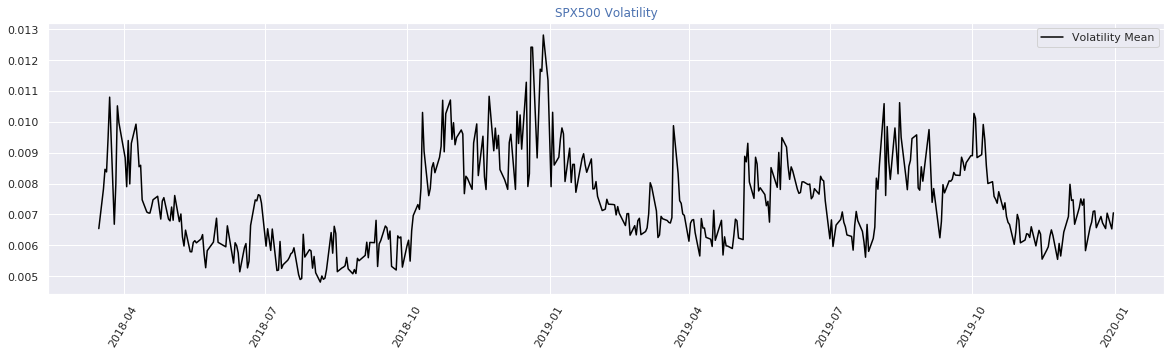

In [17]:
volatility_mean = np.average(ms_s, axis=1)

sns.set()
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('SPX500 Volatility'.format("seaborn"), color='C0')
returnUs = np.array(us)
DeltaUs = np.abs(np.array(returnUs[1:,-1]) - np.array(returnUs[:-1,-1]))

ax.plot(all_days[1:], volatility_mean[2:], color="black")
# ax.plot(all_days[2:], DeltaUs[1:], color = "green", linestyle="--", alpha = 0.5)

# ax.plot([i for i in range(len(volatility_mean)-2)], volatility_mean[2:], color="black")
# ax.plot([i for i in range(len(DeltaUs)-1)], DeltaUs[1:], color = "green", linestyle="--", alpha = 0.5)

ax.legend(['Volatility Mean', "Delta Difference"])
plt.xticks(rotation=60)
plt.show()

In [ ]:
avger = np.ones(theta_dim)/theta_dim
volatility_var = []
for p in Cs_s:
    one_var = np.matmul(avger, np.matmul(p, avger.T))
    volatility_var.append(one_var)


# 睡觉专区

In [43]:
np.random.seed(1234)
gradient = grad(loss)


for alpha in np.arange(0.5, 20, 0.5):

    m_t_1 = [np.array([0]), np.array([0]), np.array([0])]
    v_t_1 = [np.array([0]), np.array([0]), np.array([0])]
    beta_1 = 0.9
    beta_2 = 0.999
    epsillon = 0.00000001
    
    print("alpha = {}".format(alpha))
    theta_dim = 16
    connectivity = 0.4
    spectral_radius = 0.98
    bday_p_year = 252
    bias = -7

    v_scale = 100.0
    target_var = 4
    chi_mu = math.sqrt(2)* math.gamma((theta_dim+1)/2) / math.gamma(theta_dim/2)
    W_scale = target_var+chi_mu

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    W = np.eye(theta_dim)*W_scale
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    
    for em_itr in range(200):
        dt=1
        points = MerweScaledSigmaPoints(theta_dim, alpha=.001, beta=2., kappa=0)
        ukf = UnscentedKalmanFilter(dim_x=ESN.theta_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
        ukf.x = np.ones(ESN.theta_dim)* 0.002 # initial state
        ukf.P *= 0.01 # initial uncertainty
        ukf.R = np.diag([v]*topK) # 1 standard
        ukf.Q = W

        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            p_t = data[day][0]["spotclose"].values[0]
            r_t = data[day][1] / bday_p_year
            u_t = data[day][2].reshape([-1])

            ## Option wise data
            y_t = data[day][0]["close2"].values
            K_t = data[day][0]["strike"].values
            today = [d.date() for d in data[day][0]["date"]]
            expireday = [d.date() for d in data[day][0]["expirydate"]]
            T_t = np.busday_count(today, expireday)


            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother(ms, Cs, fx=ESNf, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_s=us)


        params = [ESN.G, ESN.G_in, ESN.b, ukf.Q, v]

        step = 0.02
        try:
            curr_loss = loss(params,
                             ms_s, Cs_s, cvs_s,
                             u_quad_s,
                             ps, rs, Ks, Ts, ys,
                             num_observations,
                             reg=alpha)
            curr_grad = gradient(params,
                                 ms_s, Cs_s, cvs_s,
                                 u_quad_s,
                                 ps, rs, Ks, Ts, ys,
                                 num_observations,
                                 reg=alpha)

######################## Adam Optimizer ###########################
            
            m_t = [None, None, None]
            v_t = [None, None, None]
            m_t_hat = [None, None, None]
            v_t_hat = [None, None, None]

            m_t[0] = beta_1 * m_t_1[0] + (1-beta_1) * curr_grad[0]
            v_t[0] = beta_2 * v_t_1[0] + (1-beta_2) * (curr_grad[0] * curr_grad[0])
            m_t_hat[0] = m_t[0] / (1-beta_1 ** (em_itr+1))
            v_t_hat[0] = v_t[0] / (1-beta_2 ** (em_itr+1))
            params[0] -= step * m_t_hat[0] / (np.sqrt(v_t_hat[0]) + epsillon)

            m_t[1] = beta_1 * m_t_1[1] + (1-beta_1) * curr_grad[1]
            v_t[1] = beta_2 * v_t_1[1] + (1-beta_2) * (curr_grad[1] * curr_grad[1])
            m_t_hat[1] = m_t[1] / (1-beta_1 ** (em_itr+1))
            v_t_hat[1] = v_t[1] / (1-beta_2 ** (em_itr+1))
            params[1] -= step * m_t_hat[1] / (np.sqrt(v_t_hat[1]) + epsillon)

            m_t[2] = beta_1 * m_t_1[2] + (1-beta_1) * curr_grad[2]
            v_t[2] = beta_2 * v_t_1[2] + (1-beta_2) * (curr_grad[2] * curr_grad[2])
            m_t_hat[2] = m_t[2] / (1-beta_1 ** (em_itr+1))
            v_t_hat[2] = v_t[2] / (1-beta_2 ** (em_itr+1))
            params[2] -= step * m_t_hat[2] / (np.sqrt(v_t_hat[2]) + epsillon)

            m_t = m_t_1
            v_t = v_t_1

######################### SGD Optimizer ###########################

#                 params[0] -= step * curr_grad[0]  # ESN.G
#                 params[1] -= step * curr_grad[1]  # ESN.G_in
#                 params[2] -= step * curr_grad[2]  # ESN.b

###################################################################

        except RuntimeWarning or LinAlgError or OverflowError:
            print("Error occured")
            pass

        ESN.G, ESN.G_in, ESN.b, W, v = params

        np.delete(ms_s,0,0)
        np.delete(Cs_s,0,0)
        prediction_errors = []
        ukf.x = ms_s[0]
        ukf.P = Cs_s[0]
        for i in range(1, len(ms_s)-1):

            pred_state = ESNf(ms_s[i-1], 0, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_quad_now=u_quad_s[i])
            pred_price = BSf(pred_state, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
            error = np.average(np.abs(ys[i]-pred_price) /ys[i])
            prediction_errors.append(error)


        avg_error = np.average(prediction_errors)


        print("EM Iteration {} | Loss: {:.4f} | Predict Error: {:.4f} | Dynamic var {:.2f} | Obs var {:.2f}".format(
            em_itr, curr_loss, avg_error, W[0,0], v))
        
        if last_avg_error < avg_error and em_itr-best_itr >= 10:
            break
        elif last_avg_error < avg_error and em_itr-best_itr < 10:
            pass
        elif last_avg_error > avg_error and em_itr-best_itr < 10:
            last_avg_error = avg_error
            best_itr = em_itr
        
            
    print("best prediction error: {} at {}th iteration | alpha = {}".format(last_avg_error, em_itr-1, alpha))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

alpha = 0.5
EM Iteration 0 | Loss: 41.9342 | Predict Error: 0.7923 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 1 | Loss: 32.2553 | Predict Error: 0.7906 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 2 | Loss: 25.6153 | Predict Error: 0.7891 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 3 | Loss: 20.4837 | Predict Error: 0.7876 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 4 | Loss: 16.2573 | Predict Error: 0.7863 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 5 | Loss: 12.5989 | Predict Error: 0.7850 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 6 | Loss: 9.4338 | Predict Error: 0.7837 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 7 | Loss: 6.6786 | Predict Error: 0.7824 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 8 | Loss: 4.3915 | Predict Error: 0.7811 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 9 | Loss: 2.4937 | Predict Error: 0.7798 | Dynamic var 7.94 | Obs var 100.00
EM Iteration 10 | Loss: 0.9379 | Predict Error: 0.7784 | Dynamic var 7.94 | Obs va

KeyboardInterrupt: 